In [2]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [3]:
# load files
domain1 = pd.read_json("./Data/domain1_train.json", lines = True)
domain2 = pd.read_json("./Data/domain2_train.json", lines = True)
test = pd.read_json("./Data/test_set.json", lines = True)

## Method 1: Single Model on doamin 2
Try to solve label imbalance problem

In [6]:
# drop 'model' in domain 2
domain2_new = domain2.drop(columns=['model'])

X2_train, X2_test = train_test_split(domain2_new, test_size=0.2, random_state=90051)

vectorizer = CountVectorizer() 
X2_train_vec = vectorizer.fit_transform([' '.join(str(word_id) for word_id in doc) for doc in X2_train['text']]).toarray()
X2_test_vec = vectorizer.transform([' '.join(str(word_id) for word_id in doc) for doc in X2_test['text']]).toarray()
X1_vec = vectorizer.transform([' '.join(str(word_id) for word_id in doc) for doc in domain1['text']]).toarray()

# scale BoW, use the first 200 words
scaler = StandardScaler()
X2_train_sd = scaler.fit_transform(X2_train_vec[:, :200])
X2_test_sd = scaler.transform(X2_test_vec[:, :200]) 
X1_vec_sd = scaler.transform(X1_vec[:, :200])

In [7]:
svm_mod1 = SVC(class_weight='balanced').fit(X2_train_sd, X2_train['label'])
print("training score: {}".format(svm_mod1.score(X2_train_sd, X2_train['label'])))
print("test score: {}".format(svm_mod1.score(X2_test_sd, X2_test['label'])))
print("accuracy on domain 1: {}".format(svm_mod1.score(X1_vec_sd, domain1['label'])))

training score: 0.8656879194630872
test score: 0.7728187919463088
accuracy on domain 1: 0.5011794871794871


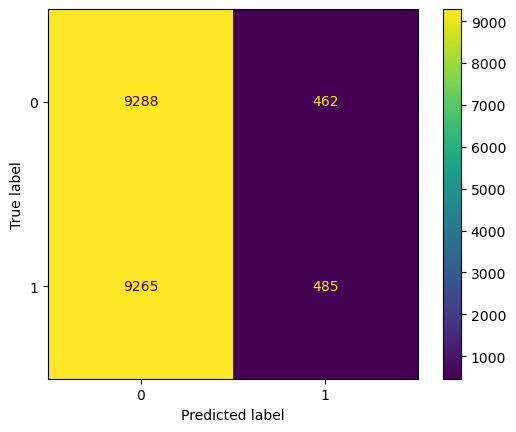

In [8]:
from sklearn.metrics import ConfusionMatrixDisplay
cm = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(domain1['label'], svm_mod1.predict(X1_vec_sd)))
cm.plot()

This model is bad even with consideration of label immbalance problem.
## Method 2: combine two datasets
training data: all of domain 2 + 80% of domain 1

test data: remaining 20% of domain 1

With label imbalance problem considered

In [9]:
# Splitting domain 1 into 80% training and 20% testing
X1_train_new, X1_test_new = train_test_split(domain1, test_size=0.2, random_state=90051)

# Combining all of domain 2 and 80% of domain 1 for the training set
X_train_combined = pd.concat([X1_train_new, domain2_new])

# The test set remains as the 20% from domain 1
X_test_combined = X1_test_new

X_train_combined_vec = vectorizer.fit_transform([' '.join(str(word_id) for word_id in doc) for doc in X_train_combined['text']]).toarray()
X_test_combined_vec = vectorizer.transform([' '.join(str(word_id) for word_id in doc) for doc in X_test_combined['text']]).toarray()
test_vec = vectorizer.transform([' '.join(str(word_id) for word_id in doc) for doc in test['text']]).toarray()

# scale BoW, use the first 200 words
scaler = StandardScaler()
X_train_combined_sd = scaler.fit_transform(X_train_combined_vec[:, :200])
X_test_combined_sd = scaler.transform(X_test_combined_vec[:, :200])
test_sd = scaler.transform(test_vec[:, :200])

In [10]:
svm_mod2 = SVC(class_weight='balanced').fit(X_train_combined_sd, X_train_combined['label'])
print("training score: {}".format(svm_mod2.score(X_train_combined_sd, X_train_combined['label'])))
print("test score: {}".format(svm_mod2.score(X_test_combined_sd, X_test_combined['label'])))

training score: 0.7464262295081967
test score: 0.7192307692307692


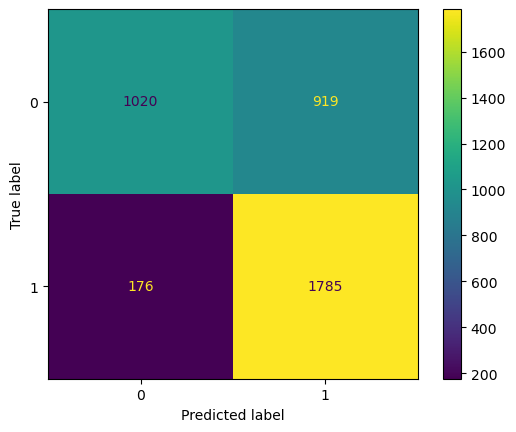

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay
cm = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(X_test_combined['label'], svm_mod2.predict(X_test_combined_sd)))
cm.plot()

SVM model on domain1+domain2 is worse than that of Logistic model, as both traning and test score are lower.

## Kaggle predict

In [12]:
test_predictions = svm_mod2.predict(test_sd)

# Create a DataFrame with IDs and predictions
result_df = pd.DataFrame({
    'id': test['id'],
    'class': test_predictions
})

# Save the results to a CSV file
csv_file_path = "./Data/svm_domain1+2.csv"
result_df.to_csv(csv_file_path, index=False)

csv_file_path

'./Data/svm_domain1+2.csv'

## Method 3: Weighted ensemble

In [8]:
# Splitting the datasets into training and testing sets
X1_train, X1_test = train_test_split(domain1, test_size=0.2, random_state=90051)
X2_train, X2_test = train_test_split(domain2, test_size=0.2, random_state=90051)

X1_train_vec = vectorizer.fit_transform([' '.join(str(word_id) for word_id in doc) for doc in X1_train['text']]).toarray()
X1_test_vec = vectorizer.transform([' '.join(str(word_id) for word_id in doc) for doc in X1_test['text']]).toarray()
X2_train_vec = vectorizer.fit_transform([' '.join(str(word_id) for word_id in doc) for doc in X2_train['text']]).toarray()
X2_test_vec = vectorizer.transform([' '.join(str(word_id) for word_id in doc) for doc in X2_test['text']]).toarray()

# scale BoW, use the first 200 words
X1_train_sd = scaler.fit_transform(X1_train_vec[:, :200])
X1_test_sd = scaler.transform(X1_test_vec[:, :200])
X2_train_sd = scaler.fit_transform(X2_train_vec[:, :200])
X2_test_sd = scaler.transform(X2_test_vec[:, :200])

In [9]:
model1 = SVC(class_weight='balanced', probability=True).fit(X1_train_sd, X1_train['label'])
model2 = SVC(class_weight='balanced', probability=True).fit(X2_train_sd, X2_train['label'])

# Get accuracy on test data for both models
accuracy1 = model1.score(X1_test_sd, X1_test['label'])
accuracy2 = model2.score(X2_test_sd, X2_test['label'])

accuracy1, accuracy2

(0.7256410256410256, 0.7728187919463088)

In [10]:
def weighted_ensemble_prediction(model1, model2, weight1, weight2, X):
    """Compute weighted ensemble predictions for given input data."""
    proba1 = model1.predict_proba(X)[:, 1]  # Probability for positive class from model 1
    proba2 = model2.predict_proba(X)[:, 1]  # Probability for positive class from model 2
    
    weighted_proba = (weight1 * proba1 + weight2 * proba2) / (weight1 + weight2)
    
    return (weighted_proba > 0.5).astype(int)

# Compute ensemble predictions for test data from both datasets
y1_pred_ensemble = weighted_ensemble_prediction(model1, model2, accuracy1, accuracy2, X1_test_sd)
y2_pred_ensemble = weighted_ensemble_prediction(model1, model2, accuracy1, accuracy2, X2_test_sd)

# Compute accuracy for ensemble predictions
accuracy1_ensemble = np.mean(y1_pred_ensemble == X1_test['label'])
accuracy2_ensemble = np.mean(y2_pred_ensemble == X2_test['label'])

accuracy1_ensemble, accuracy2_ensemble

(0.4971794871794872, 0.8516778523489933)

The weighted model is not good.

SVM:
1. single model on domain 2 taken into consideration of label imbalance problem, the accuracy is low.
2. combine the two datasets, the training and test score are not ideal. -> Kaggle accuracy 0.604
3. weighted model performces badly.